# Conditional Restricted Boltzmann Machines in R

### CRBM training and testing algorithms, coded in plain R.
Here you can find _Graham Taylor_'s Conditional Restricted Boltzmann Machines approach, implemented in R, and in plain algorithm (without vectorization or Theano optimization), for academic and educational purposes. You will notice that we kept the original variable and function names, and some of the comments from Taylor's to guide the reader, also to compare this implementation against the original one in Python.

@authors Josep Ll. Berral, David Buchaca (Barcelona Supercomputing Center)

@date 22nd November, 2016

### Main Reference
Code based on <a href="http://www.uoguelph.ca/~gwtaylor/">Graham Taylor</a>'s CRBM in Matlab and Theano
* Source (Theano): https://gist.github.com/gwtaylor/2505670
* Source (Matlab): http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/code.html
* Reference: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/gwtaylor_nips.pdf

### Mocap data
* R converted version: TODO - Here goes link to motion.rds
* Original file: http://www.uoguelph.ca/~gwtaylor/publications/nips2006mhmublv/motion.mat
* Data originally from Eugene Hsu, MIT. http://people.csail.mit.edu/ehsu/work/sig05stf/

## GENERIC FUNCTIONS

* **sample_normal**: Generates a matrix of random normal values
* **sample_bernoulli**: Generates a matrix of Bernoulli samples given a matrix of probabilities
* **sigmoid_func**: Performs the sigmoid calculus over a matrix

In [1]:
## Function to produce Normal Samples
sample_normal <- function(dims, mean = 0, sd = 1)
{
    array(rnorm(n = prod(dims), mean = mean, sd = sd), dims);
}

## Function to produce Bernoulli Samples
sample_bernoulli <- function(mat)
{
    dims <- dim(mat);
    array(rbinom(n = prod(dims), size = 1, prob = c(mat)), dims);
}

## Function to produce the Sigmoid
sigmoid_func <- function(mat)
{
    1 / (1 + exp(-mat));
}

## CRBM Functions

Functions for creating and operating CRBMs:

* **create_crbm**: The constructor function
* **free_energy_crbm**: The target cost function
* **sample_h_given_v_crbm**: Activation function given input
* **sample_v_given_h_crbm**: Reconstruction function given activations
* **gibbs_hvh_crbm**: One step of Gibbs sampling from Hidden-Visible-Hidden
* **gibbs_vhv_crbm**: One step of Gibbs sampling from Visible-Hidden-Visible
* **get_cost_updates_crbm**: One step of Contrastive Divergence (CD-k) process updating the CRBM

In [2]:
## Conditional Restricted Boltzmann Machine (CRBM). Constructor
## - A, B, W, hbias, vbias -> NULL for standalone CRBMs, in DBNs weights are shared between CRBMs and NNs
create_crbm <- function (n_visible = 49, n_hidden = 100, delay = 6, A = NULL, B = NULL, W = NULL, hbias = NULL, vbias = NULL, rand_seed = 1234)
{
    set.seed(rand_seed);

    if (is.null(W)) W <- 0.01 * sample_normal(c(n_visible, n_hidden));                  # DIMS - W (n_vis x n_hid)
    if (is.null(A)) A <- 0.01 * sample_normal(c(n_visible * delay, n_visible));         # DIMS - A ((n_vis * delay) x n_vis)
    if (is.null(B)) B <- 0.01 * sample_normal(c(n_visible * delay, n_hidden));          # DIMS - B ((n_vis * delay) x n_hid)

    if (is.null(hbias)) hbias <- rep(0, n_hidden);                                      # DIMS - hb <n_hid>
    if (is.null(vbias)) vbias <- rep(0, n_visible);                                     # DIMS - vb <n_vis>

    list(n_visible = n_visible, n_hidden = n_hidden, delay = delay, W = W, A = A, B = B, hbias = hbias, vbias = vbias);
}

## Function to compute the free energy of a sample conditional on the history
free_energy_crbm <- function(crbm, v_sample, v_history)
{
    wx_b <- t(t(v_sample %*% crbm$W + v_history %*% crbm$B) + crbm$hbias);              # DIMS - (n_seq x n_hid)
    ax_b <- t(t(v_history %*% crbm$A) + crbm$vbias);                                    # DIMS - (n_seq x n_vis)
    visible_term <- rowSums(0.5 * `^`(v_sample - ax_b,2));                              # DIMS - <n_seq>
    hidden_term <- rowSums(log(1 + exp(wx_b)));                                         # DIMS - <n_seq>

    (visible_term - hidden_term);
}

### This function infers state of hidden units given visible units
sample_h_given_v_crbm <- function(crbm, v0_sample, v_history)
{
    # propagate the visible units activation upwards to the hidden units.
    # compute the activation of the hidden units given a sample of the visibles
    pre_sigmoid_h1 <- t(t(v0_sample %*% crbm$W + v_history %*% crbm$B) + crbm$hbias);   # pre_sigmoid activation. DIMS - (n_seq x n_hid)
    h1_mean <- sigmoid_func(pre_sigmoid_h1);                                            # sigmoid values. DIMS - (n_seq x n_hid)

    # get a sample of the hiddens given their activation
    h1_sample <- sample_bernoulli(h1_mean);                                             # hidden activations. DIMS - (n_seq x n_hid)

    list(pre_sigmoid_h1 = pre_sigmoid_h1, h1_mean = h1_mean, h1_sample = h1_sample);
}

## This function infers state of visible units given hidden units
sample_v_given_h_crbm <- function(crbm, h0_sample, v_history)
{
    # propagate the hidden units activation downwards to the visible units.
    # compute the activation of the visible given the hidden sample
    v1_mean <- t(t(h0_sample %*% t(crbm$W) + v_history %*% crbm$A) + crbm$vbias);       # mean reconstruction. DIMS - (n_seq x n_vis)

    # get a sample of the visible given their activation
    ##v1_sample <- sample_bernoulli(v1_mean);
    v1_sample <- v1_mean;                                                               # mean activation (here = mean reconstruction)

    list(v1_mean = v1_mean, v1_sample = v1_sample);
}

## This function implements one step of Gibbs sampling, starting from the hidden state
gibbs_hvh_crbm <- function(crbm, h0_sample, v_history)
{
    samplevh.aux <- sample_v_given_h_crbm(crbm, h0_sample, v_history);
    samplehv.aux <- sample_h_given_v_crbm(crbm, samplevh.aux$v1_sample, v_history);

    c(samplevh.aux, samplehv.aux);                                                      # <v1_mean, v1_sample> + <pre_sigmoid_h1, h1_mean, h1_sample>
}

## This function implements one step of Gibbs sampling, starting from the visible state
gibbs_vhv_crbm <- function(crbm, v0_sample, v_history)
{
    samplehv.aux <- sample_h_given_v_crbm(crbm, v0_sample, v_history);
    samplevh.aux <- sample_v_given_h_crbm(crbm, samplehv.aux$h1_sample, v_history);

    c(samplehv.aux,samplevh.aux);                                                       # <pre_sigmoid_h1, h1_mean, h1_sample> + <v1_mean, v1_sample>
}

## This functions implements one step of CD-k
##  param input: matrix input from batch data (n_seq x n_vis)
##  param input_hist: matrix input_history from batch data (n_seq x (n_vis * delay))
##  param lr: learning rate used to train the RBM
##  param k: number of Gibbs steps to do in CD-k
##  We assume sigma = 1, no momentum nor decay, when computing deltas
get_cost_updates_crbm <- function(crbm, input, input_history, lr, k = 1)
{
    # compute positive phase (awake)
    aux <- sample_h_given_v_crbm(crbm, input, input_history)                            # <pre_sigmoid_h1, h1_mean, h1_sample>

    ph_pre_sigmoid <- aux$pre_sigmoid_h1;                                               # DIMS - (n_seq x n_hid)
    ph_mean <- aux$h1_mean;                                                             # a.k.a. "hidstates", hidden activations. DIMS - (n_seq x n_hid)
    ph_sample <- aux$h1_sample;                                                         # DIMS - (n_seq x n_hid)

    # perform negative phase (asleep)
    data1 <- ph_sample;                                                                 # DIMS - (n_seq x n_hid)
    hist1 <- input_history;                                                             # DIMS - (n_seq x (n_vis * delay))

    nv_means <- nv_samples <- nh_pre_sigmoids <- nh_means <- nh_samples <- list();
    for (i in 1:k)
    {
        aux <- gibbs_hvh_crbm(crbm, data1, hist1);                                      # <v1_mean, v1_sample, pre_sigmoid_h1, h1_mean, h1_sample>

        nv_means[[i]] <- aux$v1_mean;                                                   # DIMS - (n_seq x n_vis)
        nv_samples[[i]] <- aux$v1_sample;                                               # DIMS - (n_seq x n_vis)

        nh_pre_sigmoids[[i]] <- aux$pre_sigmoid_h1;                                     # DIMS - (n_seq x n_hid)
        nh_means[[i]] <- aux$h1_mean;                                                   # DIMS - (n_seq x n_hid)
        nh_samples[[i]] <- aux$h1_sample;                                               # DIMS - (n_seq x n_hid)

        data1 <- aux$h1_sample;
    }

    nh_mean <- nh_means[[length(nh_means)]];                                            # a.k.a "hposteriors". DIMS - (n_seq x n_hid)
    nh_sample <- nh_samples[[length(nh_samples)]];                                      # hidden activation. DIMS - (n_seq x n_hid)

    nv_mean <- nv_means[[length(nv_means)]];                                            # visible reconstruction (here = nv_sample). DIMS - (n_seq x n_vis)
    nv_sample <- nv_samples[[length(nv_samples)]];                                      # a.k.a. "negdata", visible reconstruction. DIMS - (n_seq x n_vis)

    # function to minimize - just here, passing by...
    cost <- mean(free_energy_crbm(crbm, input, input_history)) -
        mean(free_energy_crbm(crbm, nv_sample, input_history));

    # determine gradients on CRBM parameters
    Delta_W <- lr * ((t(input) %*% ph_mean) - (t(nv_sample) %*% nh_mean));              # Delta W. DIMS - (n_vis x n_hid)
    Delta_v <- lr * colMeans(input - nv_sample);                                        # Delta vbias. DIMS - <n_vis>
    Delta_h <- lr * colMeans(ph_mean - nh_mean);                                        # Delta hbias. DIMS - <n_hid>

    Delta_A <- lr * (t(input_history) %*% input - t(input_history) %*% nv_sample);      # Delta A. DIMS - ((n_vis * delay) x n_vis)
    Delta_B <- lr * (t(input_history) %*% ph_mean - t(input_history) %*% nh_mean);      # Delta B. DIMS - ((n_vis * delay) x n_hid)

    # update weights
    crbm$W <- crbm$W + Delta_W;
    crbm$A <- crbm$A + Delta_A * 0.01; # For some experiments we just give the whole weight
    crbm$B <- crbm$B + Delta_B;
    crbm$vbias <- crbm$vbias + Delta_v;
    crbm$hbias <- crbm$hbias + Delta_h;

    # approximation to the reconstruction error: sum over dimensions, mean over cases
    list(crbm = crbm, recon = mean(rowSums(`^`(input - nv_mean,2))));
}


## How to train your CRBM

Functions to train a CRBM from a loaded DataSet:

* **train_crbm**: Creates and trains a CRBM from a given dataset

In [3]:
## This is demonstrated on mocap data.
##  :param learning_rate: learning rate used for training the CRBM
##  :param training_epochs: number of epochs used for training
##  :param dataset: loaded dataset <batchdata, seqlen, data_mean, data_std> for Motion
##  :param batch_size: size of a batch used to train the CRBM
train_crbm <- function (dataset, learning_rate = 1e-5, training_epochs = 300, batch_size = 100, n_hidden = 100, delay = 6)
{
    set.seed(123);

    # prepare indexes for MOTION dataset
    batchdata <- dataset$batchdata;
    seqlen <- dataset$seqlen;

    # compute number of minibatches for training, validation and testing
    n_train_batches <- ceiling(nrow(batchdata) / batch_size);            # a.k.a. "numbatches"
    n_dim <- ncol(batchdata);                                            # a.k.a. "numdims"

    # valid starting indices
    batchdataindex <- NULL;
    last <- 1;
    for (s in seqlen)
    {
        batchdataindex <- c(batchdataindex, (last + delay):(last + s - 1));
        last <- last + s;
    }
    permindex <- batchdataindex[sample(1:length(batchdataindex),length(batchdataindex))];


    # construct the CRBM object
    crbm <- create_crbm(n_visible = n_dim, n_hidden = n_hidden, delay = delay, rand_seed = 123);

    start_time <- Sys.time();

    # go through the training epochs
    for (epoch in 1:training_epochs)
    {
        # go through the training set
        mean_cost <- NULL;

        for (batch_index in 1:n_train_batches)
        {
            # indexing is slightly complicated
            # build a linear index to the starting frames for this batch
            # (i.e. time t) gives a batch_size length array for data
            idx.aux.ini <- (((batch_index - 1) * batch_size) + 1);       # In R, stuff starts at "1"
            idx.aux.fin <- (batch_index * batch_size);
            if (idx.aux.fin > length(permindex)) break;
            data_idx <- permindex[idx.aux.ini:idx.aux.fin];              # DIMS - <batch_size>

            # now build a linear index to the frames at each delay tap
            # (i.e. time t-1 to t-delay)
            # gives a batch_size x delay array of indices for history
            hist_idx <- c(t(sapply(1:delay, function(x) data_idx - x))); # DIMS - <batch_size x delay>

            # update the CRBM parameters
            input <- batchdata[data_idx,];
            bd <- c(t(batchdata[hist_idx,]));
            input_history <- t(array(bd,c(delay * n_dim,batch_size)));

            # get the cost and the gradient corresponding to one step of CD-k
            aux <- get_cost_updates_crbm(crbm, input, input_history, lr = learning_rate, k = 1);
            this_cost <- aux$recon;
            crbm <- aux$crbm;

            mean_cost <- c(mean_cost, this_cost);
        }
        if (epoch %% 10 == 0) print(paste('Training epoch ',epoch,', cost is ',mean(mean_cost, na.rm = TRUE),sep=""));
    }

    end_time <- Sys.time();
    pretraining_time <- end_time - start_time;
    print(paste('Training took', (pretraining_time/60),'minutes',sep=" "));

    crbm;
}


## Predicting Values

Functions to predict a sequence from a CRBM:

* **predict_crbm** (a.k.a. generate_crbm): Generates _n_ samples from an input and some history using a CRBM

In [4]:
## Given initialization(s) of visibles and matching history, generate n_samples in future.
##  orig_data : n_seq by n_visibles array, initialization for first frame
##  orig_history : n_seq by delay * n_visibles array, delay-step history
##  n_samples : int, number of samples to generate forward
##  n_gibbs : int, number of alternating Gibbs steps per iteration
predict_crbm <- function(crbm, orig_data, orig_history, n_samples, n_gibbs = 30)
{
    n_seq <- nrow(orig_data);

    persistent_vis_chain <<- orig_data;                # DIMS - (n_seq x n_vis)
    persistent_history <<- orig_history;               # DIMS - (n_seq x (n_vis * delay))

    # construct the function that implements our persistent chain.
    # we generate the "mean field" activations for plotting and the actual
    # samples for reinitializing the state of our persistent chain
    sample_fn <- function(crbm, n_gibbs)
    {
        data1 <- persistent_vis_chain;
        hist1 <- persistent_history;

        presig_hids <- hid_mfs <- hid_samples <- vis_mfs <- vis_samples <- list();
        for (k in 1:n_gibbs)
        {
            aux <- gibbs_vhv_crbm(crbm, data1, hist1); # list <pre_sigmoid_h1, h1_mean, h1_sample, v1_mean, v1_sample>

            presig_hids[[k]] <- aux$pre_sigmoid_h1;
            hid_mfs[[k]] <- aux$h1_mean;
            hid_samples[[k]] <- aux$h1_sample;
            vis_mfs[[k]] <- aux$v1_mean;
            vis_samples[[k]] <- aux$v1_sample;

            data1 <- aux$v1_sample;
        }

        # add to updates the shared variable that takes care of our persistent chain
        # 1) initialize next visible with current visible
        # 2) shift the history one step forward
        persistent_vis_chain <<- vis_samples[[length(vis_samples)]];
        persistent_history <<- cbind(vis_samples[[length(vis_samples)]], persistent_history[,1:((crbm$delay - 1) * crbm$n_visible)]);

        list(vis_mfs = vis_mfs[[length(vis_mfs)]], vis_samples = vis_samples[[length(vis_samples)]]);
    }

    generated_series <- array(0,c(n_seq, n_samples, crbm$n_visible));
    for (t in 1:n_samples)
    {
        if (t %% 10 == 1) print(paste("Generating frame ", t, "-", min((t + 9),n_samples), sep = ""));
        aux <- sample_fn(crbm, n_gibbs);
        vis_mf <- aux$vis_mfs;
        vis_sample <- aux$vis_samples;
        generated_series[,t,] <- vis_mf;
    }
    generated_series;                                  # DIMS - (n_seq x n_samples x n_vis)
}

## Load Data

Functions to load data from a file name (for Motion example):

* **load_data**: Loads a motion.rds containing the Motion example data. The Motion example must be converted from Matlab format to RDS

In [5]:
## Function to Load and Preprocess the Motion Example Data.
##  :param filename: The URI of the motion.rds file with the matrix structure from Motion
##  :return list: <batchdata, seqlen, data_mean, data_std>
##  Source: TODO - motion.rds (version of motion.mat converted into R Data Storage format)
load_data <- function(filename)
{
    mat_dict <- readRDS(filename);
    Motion <- mat_dict[['Motion']];

    n_seq <- length(Motion);

    # assume data is MIT format for now
    indx <- c(1:9, 14, 19:21, 26, 31:33, 38, 43:45, 50, 55:57, 61:63, 67:69, 73:75,
                79:81, 85:87, 91:93, 97:99, 103:105);

    ##row1 <- Motion[[c(1,1)]][1,];
    ##offsets <- array(row1[c(10:12, 16:18, 22:24, 28:30, 34:36, 40:42, 46:48, 52:54,
    ##            58:60, 64:66, 70:72, 76:78, 82:84, 88:90, 94:96, 100:102,
    ##            106:108)], c(3, length(row1)/3) );

    # collapse sequences
    batchdata <- rbind(Motion[[c(1,1)]][,indx],
                       Motion[[c(2,1)]][,indx],
                       Motion[[c(3,1)]][,indx]);            # DIMS - (3826 = 438 + 260 + 3128, 49)
    data_mean <- colMeans(batchdata);                       # DIMS - <batchdata.nrow>
    data_std <- apply(batchdata, 2, sd);                    # DIMS - <batchdata.nrow>

    batchdata <- t((t(batchdata) - data_mean) / data_std);  # DIMS - <3826 x 49>

    # get sequence lengths
    seqlen <- sapply(1:3, function(x) nrow(Motion[[c(x,1)]]));

    list(batchdata = batchdata, seqlen = seqlen, data_mean = data_mean, data_std = data_std);
}


## Main Program

Example using the Motion dataset.

In [6]:
# Load data and create the CRBM
dataset <- load_data('./datasets/motion.rds');                      # List <batchdata, seqlen, data_mean, data_std>
crbm <- train_crbm(dataset);                                        # Trained CRBM

[1] "Training epoch 10, cost is 35.9749044006685"
[1] "Training epoch 20, cost is 30.2270391298677"
[1] "Training epoch 30, cost is 27.0260612244645"
[1] "Training epoch 40, cost is 24.8251468422685"
[1] "Training epoch 50, cost is 23.1074920457139"
[1] "Training epoch 60, cost is 21.6291258704409"
[1] "Training epoch 70, cost is 20.3507645985122"
[1] "Training epoch 80, cost is 19.3025927206438"
[1] "Training epoch 90, cost is 18.5107576954387"
[1] "Training epoch 100, cost is 17.789213015355"
[1] "Training epoch 110, cost is 17.177027943522"
[1] "Training epoch 120, cost is 16.7980675364592"
[1] "Training epoch 130, cost is 16.2670090665293"
[1] "Training epoch 140, cost is 15.9503242682039"
[1] "Training epoch 150, cost is 15.6285093455439"
[1] "Training epoch 160, cost is 15.3665244972125"
[1] "Training epoch 170, cost is 15.1381984766527"
[1] "Training epoch 180, cost is 14.8744299594344"
[1] "Training epoch 190, cost is 14.7222443407605"
[1] "Training epoch 200, cost is 14.559920

In [7]:
# Generate some sequences (in parallel) from CRBM
# Using training data as initialization

batchdata <- dataset$batchdata;                                     # DIMS - Motion.mat (3826, 49)

# pick some starting points for each sequence
data_idx <- c(100, 200, 400, 600);
orig_data <- batchdata[data_idx,];                                  # DIMS - Motion.mat (3826, data_idx.length)

hist_idx <- c(sapply(data_idx, function(x) x - 1:crbm$delay));
orig_history <- t(array(as.vector(t(batchdata[hist_idx,])), c(crbm$delay * crbm$n_visible, length(data_idx))));

In [8]:
generated_series.aux <- predict_crbm(crbm, orig_data, orig_history, n_samples = 100, n_gibbs = 30);

# append initialization
library(abind)
oh.temp <- aperm(array(as.vector(orig_history), c(length(data_idx), crbm$n_visible, crbm$delay)),c(1,3,2));
generated_series <- abind(oh.temp[,crbm$delay:1,], generated_series.aux, along = 2);

[1] "Generating frame 1-10"
[1] "Generating frame 11-20"
[1] "Generating frame 21-30"
[1] "Generating frame 31-40"
[1] "Generating frame 41-50"
[1] "Generating frame 51-60"
[1] "Generating frame 61-70"
[1] "Generating frame 71-80"
[1] "Generating frame 81-90"
[1] "Generating frame 91-100"


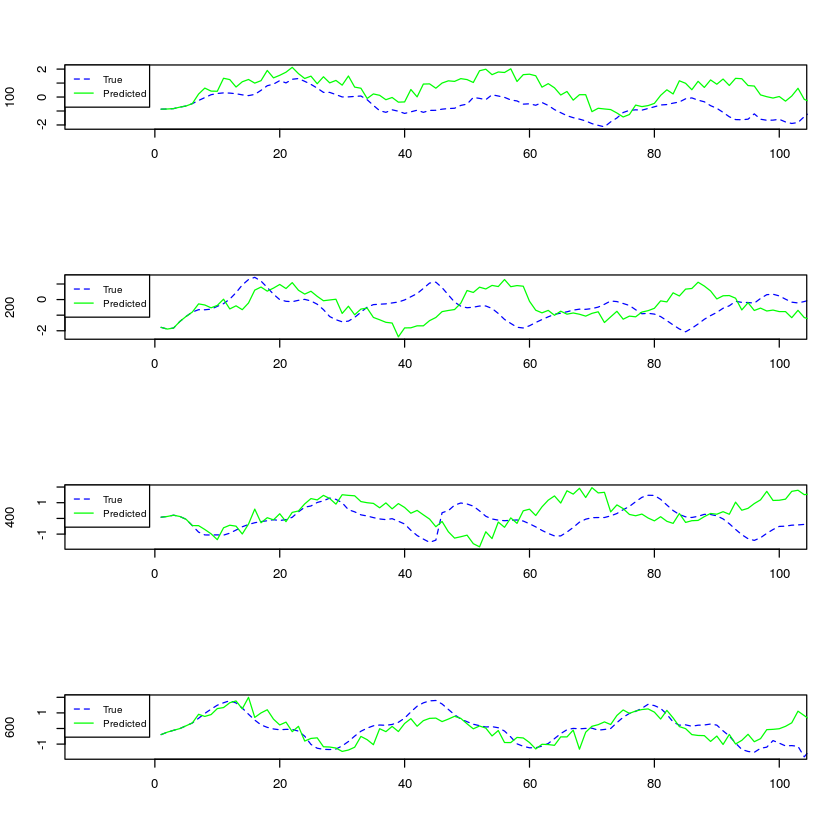

In [9]:
#plot first dimension of each sequence
par(mfrow = c(length(data_idx) ,1));
for (i in 1:length(data_idx))
{
    start <- data_idx[i];
    
    plot.true <- batchdata[(start - crbm$delay):(start + 100), 2];
    plot.pred <- generated_series[i,, 2];

    plot(plot.true, col = "blue", type = "l", lty = 2, xlab = "", ylab = data_idx[i], xlim = c(-10,100), ylim = c(min(plot.true, plot.pred),max(plot.true, plot.pred)));
    lines(plot.pred, col = "green");
    legend("topleft", legend = c("True", "Predicted"), col = c("blue","green"), lty = c(2,1), cex = 0.75, y.intersp = 1);
}